# Research Agent 

*The goal of research is to gather the context requested by the research brief.*

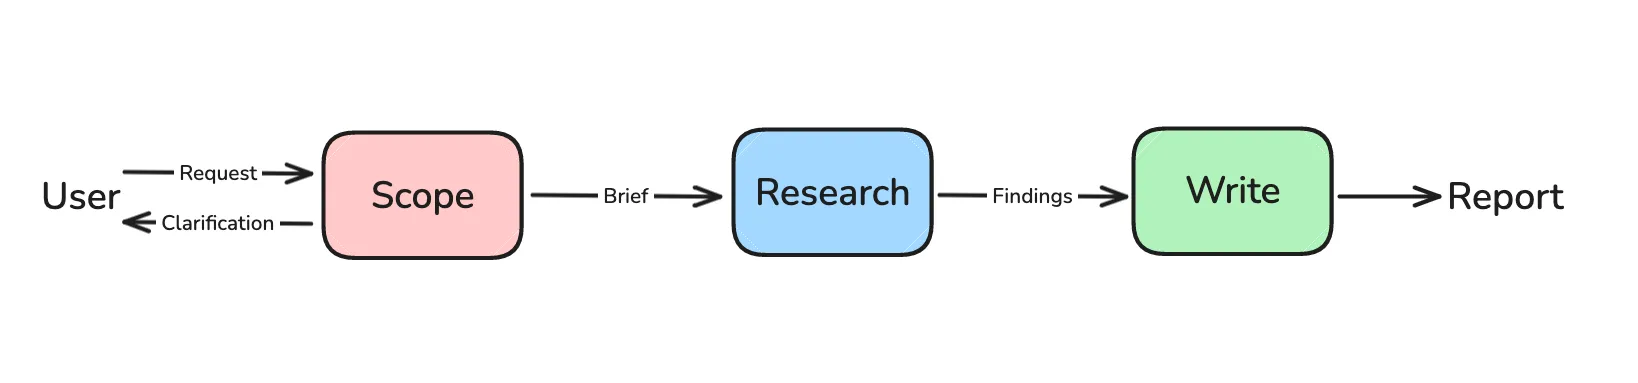

Let's build an agent that is capable of performing research on a given research brief.

## Native Search Tools

The simplest way to perform research is to use native model search tools. Model providers have integrated native search capabilities directly into their models, eliminating the need for separate search APIs or tools. For example, [Anthropic models can perform web searches natively](https://www.anthropic.com/news/web-search-api) with:

- **Integrated Search**: Claude searches the web directly during conversations
- **Real-time Information**: Access to current information without separate API calls
- **Source Citations**: Automatic citation of sources in responses
- **Configurable Limits**: Control search usage with `max_uses` parameter

OpenAI's [web search capabilities](https://platform.openai.com/docs/guides/tools-web-search?api-mode=responses) provide similar functionality:

- **Native Integration**: GPT models can search the web during inference
- **Contextual Search**: Searches are automatically triggered when current information is needed
- **Transparent Process**: Users can see when and why searches are performed
- **Response Integration**: Search results are seamlessly integrated into model responses

### Runtime Configuration in LangGraph

Let's set up a simple workflow that uses native search tools. For this we'll take advantage of LangGraph's [runtime configuration](https://langchain-ai.github.io/langgraph/how-tos/graph-api/#add-runtime-configuration), which allows us to pass dynamic settings to our workflow without rebuilding the graph. First, define a configuration schema using Pydantic:

In [1]:
from typing import Literal
from pydantic import BaseModel, Field

class SearchConfig(BaseModel):
    search_api: Literal["anthropic", "openai"] = Field(
        default="anthropic",
        description="Search API to use for research"
    )
    max_searches: int = Field(
        default=5,
        description="Maximum number of searches to perform"
    )

Next, we'll create a graph and access the configuration through the `config` parameter:

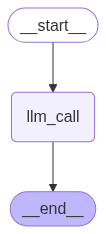

In [2]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain.chat_models import init_chat_model
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage
from IPython.display import Image, display

# Prompt 
research_prompt_native = """You are a research assistant conducting thorough research on user queries. Your goal is to provide comprehensive, well-sourced answers."""

# Workflow
def llm_call(state: MessagesState, config: RunnableConfig):
    """LLM decides whether to call a tool or not"""

    # Extract configuration to determine which search provider to use
    configurable = config.get("configurable", {})
    search_api = configurable.get("search_api", "anthropic")
    max_searches = configurable.get("max_searches", 5)
    
    # Get search tools based on configuration
    tools = []
    if search_api == "anthropic":
        # Anthropic's native web search tool
        tools = [{"type": "web_search_20250305", "name": "web_search", "max_uses": max_searches}]
        model = init_chat_model("anthropic:claude-sonnet-4-20250514")
    elif search_api == "openai":
        # OpenAI's native web search tool
        tools = [{"type": "web_search_preview"}]
        model = init_chat_model("openai:gpt-4.1")
    else:
        # Default to anthropic if unknown
        tools = [{"type": "web_search_20250305", "name": "web_search", "max_uses": max_searches}]
        model = init_chat_model("anthropic:claude-sonnet-4-20250514")
    
    # Bind tools to model and make the call
    model_with_tools = model.bind_tools(tools)
    
    # Invoke the model with search capabilities
    response = model_with_tools.invoke([
        SystemMessage(content=research_prompt_native)
    ] + state["messages"])
    
    return {"messages": [response]} 

# Build the workflow
workflow = StateGraph(MessagesState, config_schema=SearchConfig)
workflow.add_node("llm_call", llm_call)
workflow.add_edge(START, "llm_call")
workflow.add_edge("llm_call",END)

# Compile
search_workflow = workflow.compile()

# Show
display(Image(search_workflow.get_graph(xray=True).draw_mermaid_png()))

In [3]:
# Run 
config = {"configurable": {"search_api": "anthropic"}}
result = search_workflow.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]}, config=config)

In [4]:
# See messages
from utils import format_messages
format_messages(result["messages"])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ I'll help you research the best coffee shops in San Francisco by searching for current information and          │
│ recommendations.                                                                                                │
│ Let me search for more specific information about highly-rated coffee shops in San Francisco.                   │
│ Based on my research, here's a comprehensive guide to the best coffee shops in San Francisco:                   │
│                                                                                                                 │
│ ## Top Coffee Shops in San Francisco                                                                            │
│                                                                                                                 │
│ ### Premier Specialty Coffee Roasters                                                                           │
│                                                                                                                 │
│ **1. Blue Bottle Coffee**                                                                                       │
│                                                                                                                 │
│ Blue Bottle is one of San Francisco's most renowned coffee roasters, born in Oakland in 2002 and now expanded   │
│ globally. It's known for incredibly fresh, flavorful coffee and offers subscription services.                   │
│                                                                                                                 │
│ The Ferry Building location is particularly popular for its amazing views of the bay that complement a steamy   │
│ hot cappuccino.                                                                                                 │
│                                                                                                                 │
│                                                                                                                 │
│ **2. Ritual Coffee Roasters**                                                                                   │
│                                                                                                                 │
│ Ritual Coffee Roasters started the San Francisco specialty coffee conversation almost 13 years ago and is built │
│ on flavorful beans and inclusive environments.                                                                  │
│                                                                                                                 │
│ The roaster showcases excellent coffee quality with four shops in the Mission, Bayview, Napa and Hayes Valley,  │
│ maintaining partnerships with small farms in Central America, South America and Africa.                         │
│                                                                                                                 │
│ Each shop has a signature drink unique to its location, with the Hayes Valley location being a repurposed       │
│ shipping container.                                                                                             │
│                                                                                                                 │
│                                                                                                                 │
│ **3. Saint Frank Coffee**                                                                                       │
│                                                                                                                 │
│ Saint Frank is ranked by The Daily Meal as one of the top three coffee shops in America and by Thrillist as one │
│ of the top 21 coffee shops in America.                 

In [ ]:
# TODO: Explain encrypted content w/ native search tools 

## Supplying Search Tools to an Agent

Sometimes we want to supply research tools to an agent. A common way to do this is simply to define a tool using a search API. Here, we'll create an agent as described in the [LangGraph agents tutorial](https://langchain-ai.github.io/langgraph/tutorials/workflows/#agent) and give it access to a search tool. The agent loop consists of:

1. **LLM Call**: The model decides whether to call a tool or provide a final answer
2. **Tool Execution**: If tools are called, they are executed and results are gathered
3. **Iteration**: The model receives tool results and decides next steps
4. **Termination**: The loop continues until the model decides it has enough information

Here, there are some key differences from the native search workflow:

- **Explicit Tool Calls**: The model must explicitly decide when to use tools
- **Tool Message Handling**: Tool results are passed back as `ToolMessage` objects
- **Multi-turn Reasoning**: The model can reason about tool results and make additional calls
- **Routing**: The workflow uses conditional edges to decide between tool execution and completion

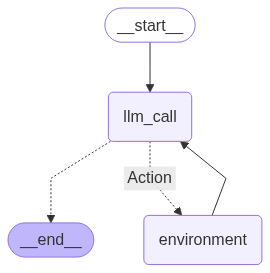

In [5]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, ToolMessage
from typing_extensions import Literal
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch

# TODO: Here let's use @tool decorator with raw search API
tool = TavilySearch(
    max_results=5,
    topic="general",
)
tools = [tool]
tools_by_name = {tool.name: tool for tool in tools}

# Initialize model
model = init_chat_model(model="openai:gpt-4.1")
model_with_tools = model.bind_tools(tools)

# Prompt
research_agent_prompt = """You are a research assistant conducting thorough research on user queries. Your goal is to provide comprehensive, well-sourced answers.

RESEARCH GUIDELINES:
1. Use search tools to gather current and relevant information
2. Search for multiple perspectives and sources when possible
3. Cite sources clearly in your responses
4. Be thorough but efficient - don't make unnecessary searches
5. If initial searches are insufficient, make additional targeted searches

SEARCH STRATEGY:
- Start with broad searches to understand the topic
- Follow up with specific searches for details or clarification
- Look for authoritative sources and recent information
- Consider different viewpoints and potential biases

RESPONSE FORMAT:
- Provide clear, well-structured answers
- Include specific facts and data points
- Cite sources using [Source Name](URL) format
- Acknowledge limitations or uncertainties when appropriate

When you have enough information to provide a comprehensive answer, stop searching and provide your final response."""

# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            model_with_tools.invoke(
                [
                    SystemMessage(
                        content=research_agent_prompt
                    )
                ]
                + state["messages"]
            )
        ]
    }
    
def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["environment", "__end__"]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]
    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "Action"
    # Otherwise, we stop (reply to the user)
    return END

# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("environment", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        # Name returned by should_continue : Name of next node to visit
        "Action": "environment",
        END: END,
    },
)
agent_builder.add_edge("environment", "llm_call")

# Compile the agent
agent = agent_builder.compile()

# Show the agent
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [6]:
# Run the workflow
result = agent.invoke({"messages": [HumanMessage(content="I want to research the best coffee shops in San Francisco.")]})
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ I want to research the best coffee shops in San Francisco.                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│ 🔧 Tool Call: tavily_search                                                                                     │
│    Args: {                                                                                                      │
│   "query": "best coffee shops in San Francisco 2024",                                                           │
│   "search_depth": "advanced"                                                                                    │
│ }                                                                                                               │
│    ID: call_rxuuxAp9CxHHnoHjSFIzcj4b                                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────────────────── 🔧 Tool Output ─────────────────────────────────────────────────╮
│ {'query': 'best coffee shops in San Francisco 2024', 'follow_up_questions': None, 'answer': None, 'images': [], │
│ 'results': [{'url': 'https://sf.eater.com/maps/best-coffee-shops-san-francisco', 'title': 'The Absolute Best    │
│ San Francisco Coffee Shops - Eater SF', 'content': 'This time around, the Coffee Movement on Balboa Street,     │
│ Poorboy Coffee, and Flywheel Coffee came off the list while Caffe Trieste, the Coffee Movement at Side A, and   │
│ Cafe Shoji joined the list.\n\n— Additional reporting by Dianne de Guzman. [...] This time around, the Coffee   │
│ Movement on Balboa Street, Poorboy Coffee, and Flywheel Coffee came off the list while Caffe Trieste, the       │
│ Coffee Movement at Side A, and Cafe Shoji joined the list.\n\n— Additional reporting by Dianne de Guzman. [...] │
│ A One-of-a-Kind, Black-Owned Coffee Roaster Will Open a New Shop on Valencia Street\nA One-of-a-Kind,           │
│ Black-Owned Coffee Roaster Will Open a New Shop on Valencia Street\nA One-of-a-Kind, Black-Owned Coffee Roaster │
│ Will Open a New Shop on Valencia Street\n\n## Telescope Coffee', 'score': 0.79845446, 'raw_content': None},     │
│ {'url': 'https://www.reddit.com/r/AskSF/comments/1di0g1l/recently_moved_to_san_francisco_looking_for_good/',    │
│ 'title': 'Recently moved to San Francisco, looking for good coffee place ...', 'content': "a great coffee shop  │
│ is Cafe de Casa! there's one in the Castro and one in Russian Hill, and also one in South SF too, if you're     │
│ ever in that", 'score': 0.6778372, 'raw_content': None}, {'url':                                                │
│ 'https://www.theinfatuation.com/san-francisco/guides/best-coffee-shops-san-francisco', 'title': 'The Best       │
│ Coffee Shops In SF - San Francisco - The Infatuation', 'content': '## Suggested Reading\n\n33 SF Coffee Shops   │
│ For Getting Work Done image\n33 SF Coffee Shops For Getting Work Done image\n\n### 33 SF Coffee Shops For       │
│ Getting Work Done\n\nIs your roommate a pain? Are you over your couch? Do you work from your laptop? Sounds     │
│ like you need a coffee shop with wifi.\n\nAn iced latte on the counter at The Coffee Movement\nAn iced latte on │
│ the counter at The Coffee Movement\n\n### The Coffee Movement\n\nCoffee\n\nNob Hill [...] 303 2nd St, San       │
│ Francisco, California 94107\n\nBakery/Cafe\n\nSoma\n\nPaper Son makes a strong case for your next morning       │
│ pitstop. They not only have great coffee drinks with Asian-inspired flavors (like a frothy pandan aerocano and  │
│ a fizzy Guava Pillow with guava puree foam and Li Hing powder), but they also have fantastic pastries. We       │
│ always endorse getting a chewy black sesame chocolate cookie or a miso everything scone to go with a cup of     │
│ whatever you’ve ordered.\n\nTaylor Gomez [...] ## How to get into Shoji\n\nWhether you go during the day or at  │
│ dinnertime, we suggest getting a reservation. Walk-ins are accepted for cafe and restaurant hours, but you may  │
│ end up sharing a booth or having to stand at the bar. The good news is that reservations, particularly before   │
│ 7pm and after 9pm, are easy to snag just a day in advance.\n\nRESERVE A TABLE WITH\n\nOpenTable logo\n\n##      │
│ Snowbird Coffee\n\n1352A 9th Ave, San Francisco, CA 94122\n\nBakery/Cafe\n\nSunset', 'score': 0.6625569,        │
│ 'raw_content': None}, {'url': 'https://m.yelp.com/search?find_desc=best+coffee&find_loc=San+Francisco%2C+CA',   │
│ 'title': 'Best Coffee San Francisco, CA - Last Updated July 2025 - Yelp', 'content': 'best coffee Near San      │
│ Francisco, California ; 1. Paper Son Coffee · (44 reviews) · 303 2nd St N102, San Francisco, CA 94107 ; 2. The  │
│ Coffee Movement · (689 reviews).', 'score': 0.595987, 'raw_content': None}, {'url':                             │
│ 'https://coffeewithdamian.com/blog/best-coffee-shops-in

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Here are some of the best coffee shops in San Francisco as of 2024, based on expert roundups and user reviews:  │
│                                                                                                                 │
│ 1. The Coffee Movement                                                                                          │
│    - Several locations, including Balboa Street and Side A                                                      │
│    - Known for its expertly crafted drinks and inviting atmosphere                                              │
│    - Frequently recommended in multiple lists                                                                   │
│    - [Details via Eater SF](https://sf.eater.com/maps/best-coffee-shops-san-francisco), [More at The            │
│ Infatuation](https://www.theinfatuation.com/san-francisco/guides/best-coffee-shops-san-francisco)               │
│                                                                                                                 │
│ 2. Paper Son Coffee                                                                                             │
│    - 303 2nd St, San Francisco, CA 94107 (SoMa area)                                                            │
│    - Praised for creative Asian-inspired drinks and excellent pastries                                          │
│    - [Details via The                                                                                           │
│ Infatuation](https://www.theinfatuation.com/san-francisco/guides/best-coffee-shops-san-francisco), [Yelp        │
│ listing](https://m.yelp.com/search?find_desc=best+coffee&find_loc=San+Francisco%2C+CA)                          │
│                                                                                                                 │
│ 3. Caffe Trieste                                                                                                │
│    - Historic North Beach café, famous for its classic Italian coffee and artistic heritage                     │
│    - Recently re-added to Eater SF's top list                                                                   │
│    - [Details via Eater SF](https://sf.eater.com/maps/best-coffee-shops-san-francisco)                          │
│                                                                                                                 │
│ 4. Cafe Shoji                                                                                                   │
│    - Known for Japanese-style drinks and unique, minimalist decor                                               │
│    - Reservation is recommended for cafe hours as it can get busy                                               │
│    - [Advice on how to visit at The                                                                             │
│ Infatuation](https://www.theinfatuation.com/san-francisco/guides/best-coffee-shops-san-francisco)               │
│                                                                                                                 │
│ 5. Snowbird Coffee                                                                                              │
│    - 1352A 9th Ave, San Francisco, CA 94122 (Sunset)                                                            │
│    - A neighborhood favorite for specialty coffee and pastries                                                  │
│    - [Details via The                                                                                           │
│ Infatuation](https://www.theinfatuation.com/san-francisco/guides/best-coffee-shops-san-francisco)               │
│                                                                                                                 │
│ 6. Cafe de Casa                                        

In [7]:
# TODO: Add lessons